# Monkey Business
## Preprocessing and Decomposition to Build Neural Decoders
Tyler Yamori-Little

The outlook of current neuroscience research is very promising. Due to newfound knowledge about the nature of the brain, it becomes possible to build and train decoders to predict motion from brain signals.

The animal brain is a dynamical system containing well over 85 billion neurons. These neurons communicate with eachother on the milisecond timescale through signals. Such links are detecable by looking at the electropotential current going through a given neuron. This is almost always constant and appears almsot random. However, there are brief moments of a higher electropotential. This phenomeon is called a spike and it is believed that these spikes are the driving force behind animal functions. 

Luckily, out of all the neurons in the brain, those within the motor cortex and somatosensory cortex play a significant role in determing motion. Thus, by looking at the interactions between these specific neurons within the two cortexes, it becomes much more probable in finding a correlation to motion. 

This notebook is intended to be a guide for a novice (such as myself) in the field of systems neuroscience who seeks to understand neural data.

## Import Data

The dataset that is used was recorded by O'Doherty et al and can be found here: https://zenodo.org/record/3854034#.YuLAeuzMKJl. The subject is a Rhesus macaque monkey named Loco. Two multielectrode silicon utah arrays were planted into the primary motor cortex(m1) and the somatosensory cortex(s1). These arrays recorded neural signals from local neuron populations at a rate of 24.4khz. Signals crossing a threshold of 3.5-4 times the standard deviation were timestamped and sorted into units. Units refer to discovered neurons using pca reduction and clustering. Furthermore, data is filtered using a casual 4th order bandpass butterworth filter with a low of 500hz and high of 5000hz. This was already preprocessed thanks to the research group. Correspoding cursor data and finger position data were recorded as well, sampled at 250hz. All data is stored as a MATLAB mat file

A trial is a standard reach trial where the subject has to reach a tile on a screen. Once reached, a juice reward is given. A sample run can be found here: https://www.youtube.com/watch?v=bPkpdpm03z8. 

In [536]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [537]:
##using h5 file to access mat data
loco2 = h5py.File('loco_20170213_02.mat','r')
list(loco2.keys())

['#refs#',
 'chan_names',
 'cursor_pos',
 'finger_pos',
 'spikes',
 't',
 'target_pos',
 'wf']

In [539]:
#Used to determine what data belongs to the m1 versus s1 arrays
chan_names = loco2['chan_names']
channel_names = np.zeros(192,dtype='object')
num_of_channels = chan_names.size
for i in range(num_of_channels):
    channel_names[i] = loco2[chan_names[0][i]]

In [540]:
print(chr(channel_names[0][0]),chr(channel_names[0][1])) #m1 
print(chr(channel_names[96][0]),chr(channel_names[96][1])) #s1

M 1
S 1


## Construct Cursor Data

In [541]:
cursor_pos = loco2['cursor_pos']
time = loco2['t'][0]
x_cursor = cursor_pos[0,:]
y_cursor = cursor_pos[1,:]
target_pos = loco2['target_pos']
x_target = target_pos[0,:]
y_target = target_pos[1,:]

(604362,)


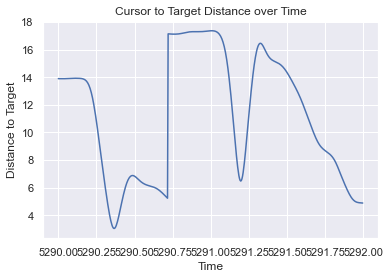

In [542]:
x_distance = abs(x_cursor-x_target)
y_distance = abs(y_cursor-y_target)
x_squared = np.power(x_distance,2)
y_squared = np.power(y_distance,2)
distance_to_target = np.sqrt(x_squared + y_squared) #standard distance formula
print(distance_to_target.shape)

plt.plot(time[0:500],distance_to_target[0:500])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Cursor to Target Distance over Time')
plt.show()

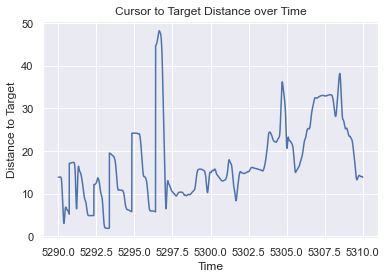

In [543]:
plt.plot(time[0:5000],distance_to_target[0:5000])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Cursor to Target Distance over Time')
plt.show()

## Find Trial Boundaries

In [544]:
x_target_shifted = [0]
x_target_original = x_target
x_target_shifted = np.append(x_target_shifted,x_target)
x_target_original = np.append(x_target_original,0)

In [545]:
x_target_difference = x_target_shifted - x_target_original
trial_boundary_indexes = []
for i, j in enumerate(x_target_difference):
    if (j!=0):
        trial_boundary_indexes = np.append(trial_boundary_indexes, i)
        
trial_boundary_indexes = trial_boundary_indexes.astype(int)

In [546]:
trial_boundary_indexes[0:10]

array([    0,   180,   584,   839,  1207,  1597,  7593,  8339,  8656,
       10007])

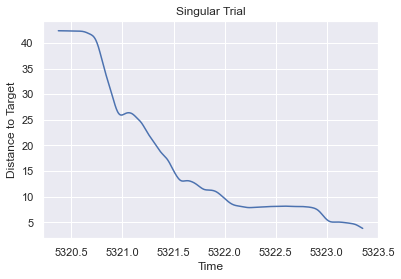

In [547]:
plt.plot(time[7593:8339],distance_to_target[7593:8339])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Singular Trial')
plt.show()

## Kinematics

In [548]:
finger_pos = loco2['finger_pos']
time = loco2['t'][0]
x_finger = finger_pos[1]
y_finger = finger_pos[2]

In [549]:
np.max(y_finger)

6.243064151515015

In [550]:
np.min(y_finger)

-7.860908432574234

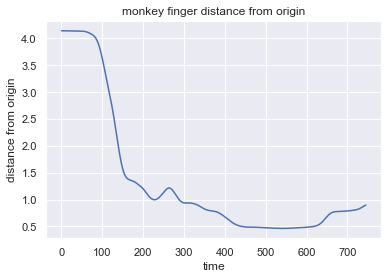

In [551]:
distance = np.sqrt(np.power(x_finger,2) + np.power(y_finger,2))
plt.plot(distance[7593:8339])
plt.xlabel('time')
plt.ylabel('distance from origin')
plt.title('monkey finger distance from origin')
plt.show()

In [553]:
#data is at .04s itervals. Velocity calculated using .16s widths
offset = np.zeros(4)
distance_shifted = offset
distance_shifted = np.append(distance_shifted,distance)
distance_original = distance
distance_original = np.append(distance_original,offset)

distance_difference = distance_shifted - distance_original

t_step = time[4]-time[0]
velocity = distance_difference / t_step
velocity = np.delete(velocity,[0,1,2,3])

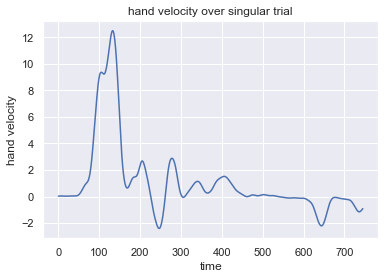

In [554]:
plt.plot(velocity[7593:8339])
plt.xlabel('time')
plt.ylabel('hand velocity')
plt.title('hand velocity over singular trial')
plt.show()

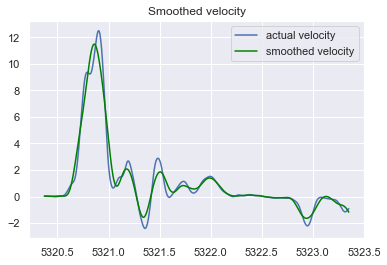

In [555]:
#It becomes necessary to smooth data later. Here is an example of what it could like using a Savitzky–Golay filter.
from scipy.signal import savgol_filter 

yhat = savgol_filter(velocity, 81, 3)

plt.plot(time[7593:8339], velocity[7593:8339], label = 'actual velocity')
plt.plot(time[7593:8339],yhat[7593:8339], color='green', label = 'smoothed velocity')
plt.title("Smoothed velocity")
plt.legend()
plt.show()

In [556]:
offset = np.zeros(4) 
velocity_shifted = offset
velocity_shifted = np.append(velocity_shifted,velocity)
velocity_original = velocity
velocity_original = np.append(velocity_original,offset)

velocity_difference = velocity_shifted - velocity_original

t_step = time[4]-time[0]
acceleration = velocity_difference / t_step
acceleration = np.delete(acceleration,[0,1,2,3])
acceleration.size

604362

In [560]:
print(distance.size)
print(velocity.size)
print(acceleration.size)

604362
604362
604362


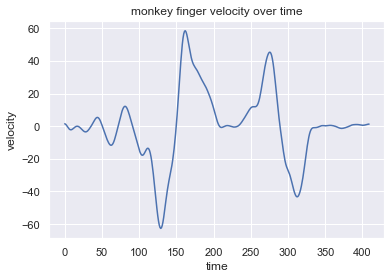

In [561]:
plt.plot(acceleration[800:1210])
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('monkey finger velocity over time')
plt.show()

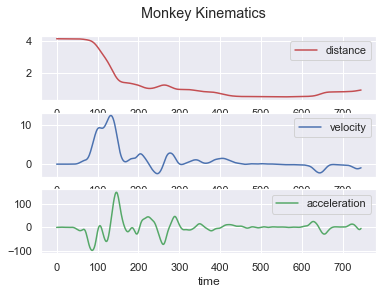

In [562]:
fig, axs = plt.subplots(3)
fig.suptitle('Monkey Kinematics')
axs[0].plot(distance[7593:8339],color = 'r', label = 'distance')
axs[1].plot(velocity[7593:8339],color = 'b', label = 'velocity')
axs[2].plot(acceleration[7593:8339],color = 'g', label = 'acceleration')

for i,j in enumerate(axs):
    axs[i].legend()
plt.xlabel('time')
plt.show()

## Constructing Raster

In [563]:
def extractSpikeData(dataset):
    #h5 uses object references to store data. This function extracts them.
    #input: dataset name where 'spikes' is the name of spike dataset
    #output: spike timstamps in array
    
    spikes = dataset['spikes']
    spike_data = np.zeros((spikes.shape),dtype='object')
    num_of_channels = len(spike_data[0])
    num_of_units = len(spike_data)
    for i in range(num_of_units):
        for j in range(num_of_channels):
            spike_data[i][j] = loco2[spikes[i,j]][0]
            
    return spike_data

In [565]:
def roundSpikes(spikes_at_channel):
    #spikes and kinematic data are misaligned in sampling rate. This function returns
    #the indexes of spike timestamps rounded to 25hz to then be used for raster construction.
    #input: vector of spikes at a channel to round
    #output: a vector of rounded spike indexes
    
    t_step = round(time[1]-time[0],3)
    t_step_for_index = 1/t_step
    t_step_for_index
    rounded_spikes = []
    for i in range(spikes_at_channel.size):
        rounded_spikes = np.append(rounded_spikes, round(spikes_at_channel[i] * t_step_for_index)/t_step_for_index)
        
    rounded_spikes = np.delete(rounded_spikes, rounded_spikes > (time[-1] - time[0]))
    rounded_spikes_index = (rounded_spikes * t_step_for_index).astype(int)
    return rounded_spikes_index

In [566]:
def constructRaster(dataset, isSorted):
    #function to construct the raster.
    #input: The name of the h5 dataset (must have 'spikes' as the key for spike data.
    #1 to include only sorted units. 0 for all spikes.
    #output: full raster where 1 is a spike and 0 is no spike at a given time.
    
    spike_data = extractSpikeData(dataset)
    raster = np.zeros(time.size)
    num_of_channels = len(spike_data[0])
    num_of_units = len(spike_data)
    units_index = 0
    
    if isSorted: #flag to construct raster based on if raster will contain sorted units or not
        units_index = 1
    for j in range(num_of_channels):
        spikes_at_channel = []
        time_at_channel = np.zeros(time.size)
        for i in range(units_index,num_of_units):
            spikes_at_channel = np.append(spikes_at_channel, spike_data[i,j])
            spikes_at_channel.sort()
            spikes_at_channel = np.delete(spikes_at_channel,spikes_at_channel == 0)

        spikes_at_channel = spikes_at_channel - time[0]
        spikes_at_channel = np.delete(spikes_at_channel,spikes_at_channel <= 0)
        rounded_spikes_at_channel = roundSpikes(spikes_at_channel)
        time_at_channel[rounded_spikes_at_channel] = 1
        raster = np.vstack((raster, time_at_channel))
    raster = np.delete(raster, 0, axis=0)
    return raster

In [568]:
raster_unsorted = constructRaster(spike_data, 0)
raster_sorted = constructRaster(spike_data, 1)

In [569]:
m1_unsorted = raster_unsorted[:96]
s1_unsorted = raster_unsorted[96:]
m1_sorted = raster_sorted[:96]
s1_sorted = raster_sorted[96:]

In [31]:
#store data into a new hdf5 file to be extracted later.
with h5py.File('monkeyData.hdf5','w') as monkey:
    monkey.create_dataset("raster_sorted", dtype='i', data=raster_sorted)
    monkey.create_dataset("raster_unsorted", dtype='i', data=raster_unsorted)
    monkey.create_dataset("m1_sorted", dtype='i', data=m1_sorted)
    monkey.create_dataset("s1_sorted", dtype='i', data=s1_sorted)
    monkey.create_dataset("m1_unsorted", dtype='i', data=m1_unsorted)
    monkey.create_dataset("s1_unsorted", dtype='i', data=s1_unsorted)
    monkey.create_dataset("hand_distance", dtype='f', data=distance)
    monkey.create_dataset("hand_velocity", dtype='f', data=velocity)
    monkey.create_dataset("hand_acceleration", dtype='f', data=acceleration)

In [570]:
monkey_data = h5py.File('monkeyData.hdf5', 'r')
monkey_data.keys()

<KeysViewHDF5 ['hand_acceleration', 'hand_distance', 'hand_velocity', 'm1_sorted', 'm1_unsorted', 'raster_sorted', 'raster_unsorted', 's1_sorted', 's1_unsorted']>

## Read Data

In [585]:
m1_sorted = np.array(monkey_data['m1_sorted'])
m1_unsorted = np.array(monkey_data['m1_unsorted'])
s1_sorted = np.array(monkey_data['s1_sorted'])
s1_unsorted = np.array(monkey_data['s1_unsorted'])
raster_sorted = np.array(monkey_data['raster_sorted'])
raster_unsorted = np.array(monkey_data['raster_unsorted'])
hand_distance = np.array(monkey_data['hand_distance'])
hand_velocity = np.array(monkey_data['hand_velocity'])
hand_acceleration = np.array(monkey_data['hand_acceleration'])

## Time Selection

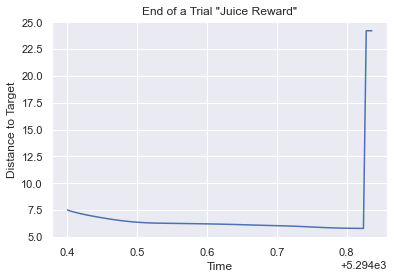

In [586]:
plt.plot(time[1100:1210],distance_to_target[1100:1210])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('End of a Trial "Juice Reward"')
plt.show()

In [587]:
trial_boundary_indexes[0:20]

array([    0,   180,   584,   839,  1207,  1597,  7593,  8339,  8656,
       10007, 11034, 11810, 12168, 13035, 13411, 13987, 14357, 14820,
       15288, 15576])

In [588]:
#around 200ms to 500ms for juice reward
juice_reward_times = []
trial_boundary = np.delete(trial_boundary_indexes,[0])
window_size = 50
for i,boundary in enumerate(trial_boundary):
    juice_reward = np.arange(boundary - window_size,boundary)
    juice_reward_times = np.append(juice_reward_times, juice_reward)
        
juice_reward_times = juice_reward_times.astype(int)
juice_reward_times[0:200]

array([ 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
        141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
        152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,
        163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
        174,  175,  176,  177,  178,  179,  534,  535,  536,  537,  538,
        539,  540,  541,  542,  543,  544,  545,  546,  547,  548,  549,
        550,  551,  552,  553,  554,  555,  556,  557,  558,  559,  560,
        561,  562,  563,  564,  565,  566,  567,  568,  569,  570,  571,
        572,  573,  574,  575,  576,  577,  578,  579,  580,  581,  582,
        583,  789,  790,  791,  792,  793,  794,  795,  796,  797,  798,
        799,  800,  801,  802,  803,  804,  805,  806,  807,  808,  809,
        810,  811,  812,  813,  814,  815,  816,  817,  818,  819,  820,
        821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,
        832,  833,  834,  835,  836,  837,  838, 11

In [589]:
#Delete the end of trial juice reward times as it will affect the BMI decoder learning.
m1_sorted = np.delete(m1_sorted,juice_reward_times, axis = 1)
m1_unsorted = np.delete(m1_unsorted,juice_reward_times, axis = 1)
s1_sorted = np.delete(s1_sorted,juice_reward_times, axis = 1)
s1_unsorted = np.delete(s1_unsorted,juice_reward_times, axis = 1)
raster_sorted = np.delete(raster_sorted,juice_reward_times, axis = 1)
raster_unsorted = np.delete(raster_unsorted,juice_reward_times, axis = 1)
hand_distance = np.delete(hand_distance,juice_reward_times)
hand_velocity = np.delete(hand_velocity,juice_reward_times)
hand_acceleration = np.delete(hand_acceleration,juice_reward_times)

## Data Smoothing

In [573]:
from scipy.signal import savgol_filter

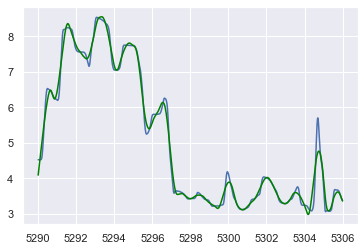

In [580]:
smoothedDistance = savgol_filter(distance, 251, 3)
plt.plot(time[0:4000], distance[0:4000])
plt.plot(time[0:4000], smoothedDistance[0:4000], color='green')
plt.show()

In [41]:
distance = smoothedDistance

## PCA Decomposition 

PCA refers to principal component analysis. It is a decomposition technique which captures the maximum variance within a given dimension. By using eigen values, the dimensionality undergoes a change of basis in terms of principal components. 

In [590]:
from scipy.stats import binned_statistic
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [591]:
#In order to PCA with meaning, the raster data must be binned to a given time width.
def binData(raster,distance,velocity, acceleration, bin_width, t_step):
    #all data binned to a given bin width
    #input: binary raster data and corresponding kinematic data. bin_width and time step in seconds. 
    
    bin_size = bin_width/t_step
    num_of_bins = int(raster[0].size/bin_size)
    binned_raster = np.zeros(num_of_bins)
    distance_data = np.arange(0, distance.size)
    velocity_data = np.arange(0, velocity.size)
    acceleration_data = np.arange(0, acceleration.size)
    
    for i in range(len(raster)):
        raster_data = np.arange(0, raster[0].size) 
        raster_bins,bin_edges, misc = binned_statistic(raster_data,raster[i], statistic="mean", bins = num_of_bins)
        binned_raster = np.vstack((binned_raster, raster_bins))

    
    binned_raster = np.delete(binned_raster, 0, axis = 0)
    binned_distance, bin_edges, misc = binned_statistic(distance_data, distance, statistic="mean", bins = num_of_bins)
    binned_velocity, bin_edges, misc = binned_statistic(velocity_data, velocity, statistic="mean", bins = num_of_bins)
    binned_acceleration, bin_edges, misc = binned_statistic(acceleration_data, acceleration, statistic="mean", bins = num_of_bins)
    
    return binned_raster, binned_distance, binned_velocity, binned_acceleration 

In [599]:
binned_raster_24ms = binData(raster_sorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)
binned_unsorted_raster_24ms = binData(raster_unsorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)

binned_raster_48ms = binData(raster_sorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)
binned_unsorted_raster_48ms = binData(raster_unsorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)

binned_raster_64ms = binData(raster_sorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)
binned_unsorted_raster_64ms = binData(raster_unsorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)

In [593]:
binned_m1_sorted_24ms = binData(m1_sorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)
binned_s1_sorted_24ms = binData(s1_sorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)

binned_m1_sorted_48ms = binData(m1_sorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)
binned_s1_sorted_48ms = binData(s1_sorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)

binned_m1_sorted_64ms = binData(m1_sorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)
binned_s1_sorted_64ms = binData(s1_sorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)

In [594]:
binned_m1_unsorted_24ms = binData(m1_unsorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)
binned_s1_unsorted_24ms = binData(s1_unsorted, hand_distance, hand_velocity, hand_acceleration, .024, .004)

binned_m1_unsorted_48ms = binData(m1_unsorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)
binned_s1_unsorted_48ms = binData(s1_unsorted, hand_distance, hand_velocity, hand_acceleration, .048, .004)

binned_m1_unsorted_64ms = binData(m1_unsorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)
binned_s1_unsorted_64ms = binData(s1_unsorted, hand_distance, hand_velocity, hand_acceleration, .064, .004)

In [595]:
def pcaData(x_train,variance):
    #pca the data using a variable variance.
    #input: raster or part of a raster(m1/s1). 
    #Variance between 0 and 1 to capture a percentage of variability
    #output: the raster in terms of principal components and the corresponding pca data object. 
    
    x_train = np.transpose(x_train)
    scalar = StandardScaler()
    x_scaled = scalar.fit_transform(x_train)
    pca_data = PCA(n_components = variance)
    principalComponenets = pca_data.fit_transform(x_scaled)
    return principalComponenets, pca_data

In [596]:
m1_pca24ms_sorted, m1_pca_data24ms_sorted = pcaData(binned_m1_sorted_24ms[0], .8)
m1_pca24ms_unsorted, m1_pca_data24ms_unsorted = pcaData(binned_m1_unsorted_24ms[0], .8)

m1_pca48ms_sorted, m1_pca_data48ms_sorted = pcaData(binned_m1_sorted_48ms[0], .8)
m1_pca48ms_unsorted, m1_pca_data48ms_unsorted = pcaData(binned_m1_unsorted_48ms[0], .8)

m1_pca64ms_sorted, m1_pca_data64ms_sorted = pcaData(binned_m1_sorted_64ms[0], .8)
m1_pca64ms_unsorted, m1_pca_data64ms_unsorted = pcaData(binned_m1_unsorted_64ms[0], .8)

In [597]:
s1_pca24ms_sorted, s1_pca_data24ms_sorted = pcaData(binned_s1_sorted_24ms[0], .8)
s1_pca24ms_unsorted, s1_pca_data24ms_unsorted = pcaData(binned_s1_unsorted_24ms[0], .8)

s1_pca48ms_sorted, s1_pca_data48ms_sorted = pcaData(binned_s1_sorted_48ms[0], .8)
s1_pca48ms_unsorted, s1_pca_data48ms_unsorted = pcaData(binned_s1_unsorted_48ms[0], .8)

s1_pca64ms_sorted, s1_pca_data64ms_sorted = pcaData(binned_s1_sorted_64ms[0], .8)
s1_pca64ms_unsorted, s1_pca_data64ms_unsorted = pcaData(binned_s1_unsorted_64ms[0], .8)

In [600]:
raster_pca_24ms = pcaData(binned_raster_24ms[0], .8)
unsorted_raster_pca_24ms = pcaData(binned_unsorted_raster_24ms[0], .8)

raster_pca_48ms = pcaData(binned_raster_48ms[0], .8)
unsorted_raster_pca_48ms = pcaData(binned_unsorted_raster_48ms[0], .8)

raster_pca_64ms = pcaData(binned_raster_64ms[0], .8)
unsorted_raster_pca_64ms = pcaData(binned_unsorted_raster_64ms[0], .8)

In [52]:
raster_pca_48ms[0].shape

(47805, 120)

In [164]:
print(m1_pca_data24ms_sorted.n_features_)
print(m1_pca_data24ms_sorted.n_features_in_)
print(m1_pca_data24ms_sorted.n_samples_)

96
96
95610


In [165]:
print(m1_pca_data48ms_sorted.n_components_)
print(s1_pca_data48ms_sorted.n_components_)

53
68


By doing PCA it is clear that the sensory cortex has much greater variability in spikes then the motor cortex

## Simple Linear Regression

It is known that the brain is a dynamical system. This section is used to show that a simple regression is very poor in determing motion from brain signals.

In [601]:
m1_input = np.transpose(m1_unsorted)
m1_input.shape
hand_velocity.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [56]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(m1_input,hand_velocity)

LinearRegression()

In [57]:
y_prediction =  LR.predict(m1_input)
y_prediction

array([ 0.04203257, -0.04895978, -0.01526422, ...,  0.07241003,
       -0.01746291,  0.06196898])

In [58]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(hand_velocity,y_prediction)
print('r2 socre is ',score)
print('mean_sqrd_error is ',mean_squared_error(hand_velocity,y_prediction))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(hand_velocity,y_prediction)))

r2 socre is  0.004485939494713986
mean_sqrd_error is  10.57220913178989
root_mean_squared error of is  3.251493369482689


In [59]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(m1_pca48ms_sorted,binned_m1_sorted_48ms[2] , test_size = 0.2, random_state = 42)

In [60]:
print(m1_pca48ms_sorted.shape)
print(binned_m1_sorted_48ms[2].shape)

(47805, 53)
(47805,)


In [61]:
x_train.shape

(38244, 53)

In [62]:
y_train.shape

(38244,)

In [63]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [64]:
y_prediction =  LR.predict(x_test)
y_prediction

array([-0.5331795 , -1.99514371,  0.55592925, ..., -0.82147929,
        1.04484286,  0.72154007])

In [65]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.04141548240309223
mean_sqrd_error is  9.253060201648342
root_mean_squared error of is  3.0418843175979493


## Constructing a  Feed Froward Nerual Network

In [366]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [242]:
data = unsorted_raster_pca_48ms[0]
print(data.shape)
distance_data = binned_unsorted_raster_48ms[1]
distance_data = np.abs(np.array(distance_data))
velocity_data = binned_unsorted_raster_48ms[2]
velocity_data = np.abs(np.array(velocity_data))
acceleration_data = binned_unsorted_raster_48ms[3]
acceleration_data = np.abs(np.array(acceleration_data))


print(velocity_data.shape)

(47805, 129)
(47805,)


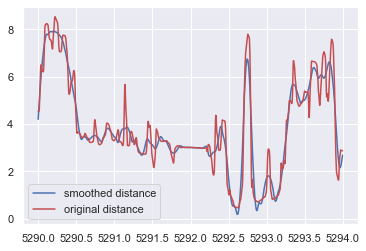

In [248]:
smoothed_distance = savgol_filter(distance_data, 51, 3)
plt.plot(time[0:1000], smoothed_distance[0:1000], label = 'smoothed distance')
plt.plot(time[0:1000], distance_data[0:1000], color = 'r', label = 'original distance')
plt.legend()
plt.show()

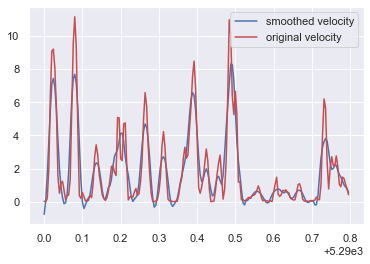

In [252]:
smoothed_velocity = savgol_filter(velocity_data, 11, 3)
plt.plot(time[0:200], smoothed_velocity[0:200], label = 'smoothed velocity')
plt.plot(time[0:200], velocity_data[0:200], color = 'r', label = 'original velocity')
plt.legend()
plt.show()

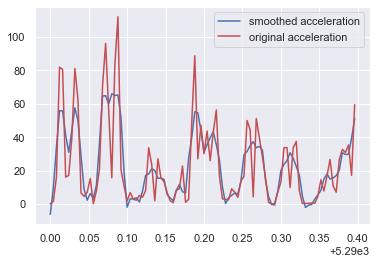

In [265]:
smoothed_acceleration = savgol_filter(acceleration_data, 7, 3)
plt.plot(time[0:100], smoothed_acceleration[0:100], label = 'smoothed acceleration')
plt.plot(time[0:100], acceleration_data[0:100], color = 'r', label = 'original acceleration')
plt.legend()
plt.show()

In [266]:
distance_data = smoothed_distance
velocity_data = smoothed_velocity
acceleration_data = smoothed_acceleration

In [303]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(data,acceleration_data, test_size = 0.2)

In [304]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [305]:
model = tf.keras.models.Sequential()
model.add(layers.Dense(129,activation = 'relu'))
model.add(layers.Dense(129,activation = 'relu'))
model.add(layers.Dense(129,activation = 'relu'))
model.add(layers.Dense(1))

In [306]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])

In [307]:
model.fit(X_train, y_train, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
955/957 [============================>.] - ETA: 0s - loss: 11.4360 - mean_squared_error: 587.9113WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f869c623cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

In [308]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 129)               16770     
                                                                 
 dense_69 (Dense)            (None, 129)               16770     
                                                                 
 dense_70 (Dense)            (None, 129)               16770     
                                                                 
 dense_71 (Dense)            (None, 1)                 130       
                                                                 
Total params: 50,440
Trainable params: 50,440
Non-trainable params: 0
_________________________________________________________________


In [309]:
prediction = model.predict(data)
prediction = prediction[:,0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1494/1494 [==============================] - 1s 895us/step


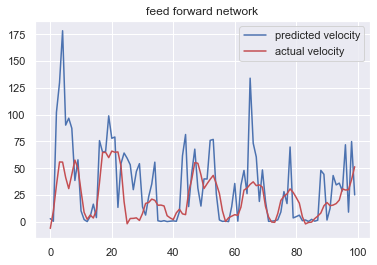

In [312]:
plt.plot(prediction[0:100], color = 'b', label = "predicted velocity")
plt.plot(acceleration_data[0:100], color = 'r', label = 'actual velocity')
plt.title("feed forward network")
plt.legend()
plt.show()

## Constructing a Recurrent Neural Network

In [480]:
data = unsorted_raster_pca_48ms[0]
print(data.shape)
distance_data = binned_unsorted_raster_48ms[1]
distance_data = np.abs(np.array(distance_data))
velocity_data = binned_unsorted_raster_48ms[2]
velocity_data = np.abs(np.array(velocity_data))
acceleration_data = binned_unsorted_raster_48ms[3]
acceleration_data = np.abs(np.array(acceleration_data))


print(velocity_data.shape)

(47805, 129)
(47805,)


In [481]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data = sc.fit_transform(data)

In [482]:
data

array([[-0.62981548,  0.14064683, -1.57222779, ..., -0.48312416,
        -0.1555888 , -0.92677318],
       [-0.30400314,  1.20831869,  0.05891218, ...,  0.68865048,
        -0.10165055,  1.29691189],
       [ 1.55184308,  2.12883962,  0.27385622, ...,  0.72970865,
        -0.11092297, -0.51850792],
       ...,
       [-1.36736197,  0.05894929, -0.40777192, ...,  0.98252746,
        -0.56220998,  0.18808106],
       [-1.37090349, -0.01337191, -0.86220615, ..., -0.55224158,
         1.01244463, -0.49180088],
       [-1.00570681, -0.25375294,  0.07908735, ...,  0.04221115,
        -0.27586177, -0.25642574]])

In [483]:
step = 1
data.shape[0]
data.shape[0]/1

data = np.reshape(data, (int(data.shape[0]/step),step,data.shape[1]))

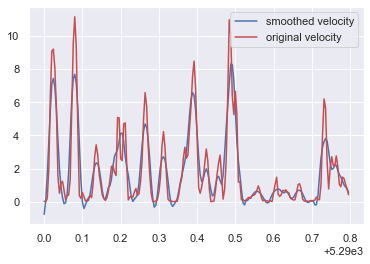

In [484]:
smoothed_velocity = savgol_filter(velocity_data, 11, 3)
plt.plot(time[0:200], smoothed_velocity[0:200], label = 'smoothed velocity')
plt.plot(time[0:200], velocity_data[0:200], color = 'r', label = 'original velocity')
plt.legend()
plt.show()

In [485]:
velocity_data = smoothed_velocity

In [487]:
data.shape

(47805, 1, 129)

In [498]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(data,velocity_data, test_size = 0.2)
test_split = .8
cutoff = data.shape[0] * test_split
cutoff = int(cutoff)
x_train = data[:cutoff,:,:]
x_test  = data[cutoff:,:,:]
y_train = velocity_data[:cutoff]
y_test  = velocity_data[cutoff:]

In [489]:
step = 1
batch_size = 10

RNN = tf.keras.models.Sequential()
RNN.add(layers.LSTM(units = 129, input_shape = (step, 129),
                    activation = 'relu', return_sequences = True))
RNN.add(layers.Dropout(0.2))
RNN.add(layers.Dense(129,activation = 'relu'))
RNN.add(layers.LSTM(units = 129, input_shape = (step, 129),
                    activation = 'relu', return_sequences = False, return_state = False))
RNN.add(layers.Dropout(0.2))
RNN.add(layers.Dense(64, activation = 'relu'))
RNN.add(layers.Dense(32))
RNN.add(layers.Dense(1))

In [490]:
RNN.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mean_squared_error',metrics = ['mean_absolute_error']) 

In [491]:
RNN.fit(x_train, y_train,batch_size = 10, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3049/3060 [============================>.] - ETA: 0s - loss: 4.4719 - mean_absolute_error: 1.3042WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f869e38fe60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERB

3060/3060 [==============================] - 8s 2ms/step - loss: 0.7687 - mean_absolute_error: 0.5785 - val_loss: 2.9908 - val_mean_absolute_error: 1.0106
Epoch 39/50
3060/3060 [==============================] - 8s 3ms/step - loss: 0.7137 - mean_absolute_error: 0.5670 - val_loss: 3.0030 - val_mean_absolute_error: 0.9982
Epoch 40/50
3060/3060 [==============================] - 8s 3ms/step - loss: 0.7254 - mean_absolute_error: 0.5695 - val_loss: 2.9859 - val_mean_absolute_error: 1.0123
Epoch 41/50
3060/3060 [==============================] - 8s 2ms/step - loss: 0.7088 - mean_absolute_error: 0.5614 - val_loss: 3.0200 - val_mean_absolute_error: 1.0060
Epoch 42/50
3060/3060 [==============================] - 8s 2ms/step - loss: 0.6945 - mean_absolute_error: 0.5572 - val_loss: 3.0178 - val_mean_absolute_error: 1.0044
Epoch 43/50
3060/3060 [==============================] - 8s 2ms/step - loss: 0.6807 - mean_absolute_error: 0.5480 - val_loss: 3.0129 - val_mean_absolute_error: 1.0182
Epoch 44/5

In [492]:
RNN.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 129)            133644    
                                                                 
 dropout_17 (Dropout)        (None, 1, 129)            0         
                                                                 
 dense_112 (Dense)           (None, 1, 129)            16770     
                                                                 
 lstm_19 (LSTM)              (None, 129)               133644    
                                                                 
 dropout_18 (Dropout)        (None, 129)               0         
                                                                 
 dense_113 (Dense)           (None, 64)                8320      
                                                                 
 dense_114 (Dense)           (None, 32)              

In [493]:
unsorted_raster_velocity_prediction = RNN.predict(x_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1196/1196 [==============================] - 2s 1ms/step


In [494]:
unsorted_raster_velocity_prediction = unsorted_raster_velocity_prediction[:,0]

In [501]:
y_train.size

38244

In [500]:
unsorted_raster_velocity_prediction.size

38244

In [502]:
stretched_prediction = []
for i,j in enumerate(unsorted_raster_velocity_prediction):
    data = [j] * 5
    stretched_prediction = np.append(stretched_prediction, data)

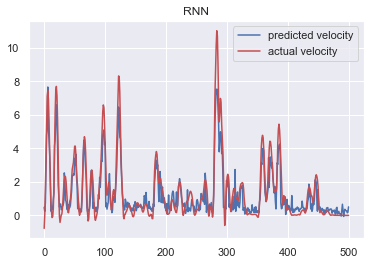

In [503]:
plt.plot(unsorted_raster_velocity_prediction[0:500], color = 'b', label = "predicted velocity")
plt.plot(y_train[0:500], color = 'r', label = 'actual velocity')
plt.title("RNN")
plt.legend()
plt.show()